We will make a simple protein secondary structure predictor for predicting one of the three classes: coil, helix and beta sheet. Similar to [psipred](http://bioinf.cs.ucl.ac.uk/psipred/), we will use a window of amino acids around a residue and feed it into a neural network, but we will only use one neural network instead of two, and we will use a window of 21, i.e. 10 amino acids to either side of the one to be predicted. 
<br>
<br> We will use a convolutional neural network with dense layers on top, and we will evaluate the quality of the predictions with the Q3 accuracy (basically accuracy across all residues) and the segment of overlap score. The segment of overlap score takes into account how much entire segments with the same secondary structure type overlap between the reference and the prediction, as opposed to the identity of individual amino acids.
<br>
<br> For training, validation and testing, we will use the data that was used to train the [jpred method](http://www.compbio.dundee.ac.uk/jpred4/about_RETR_JNetv231_details.shtml) as it is easily available and fulfills criteria such as a lack of structural/sequence homology between training and test set, which would lead to a biased evaluation.

First we'll load libraries, data and define some helper functions.

In [2]:
import numpy as np
import itertools
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
train_ids = np.loadtxt('train_names', dtype='str')
test_ids = np.loadtxt('test_names', dtype='str')

In [4]:
training_items={}
for i in train_ids:
    with open('data/training/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/training/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    training_items[i] = {'seq':seq, 'ss':ss}
    
    
test_items={}
for i in test_ids:
    with open('data/blind/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/blind/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    test_items[i] = {'seq':seq, 'ss':ss}

In [5]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

ss_id_dict = {'H':0, 'E':1, '-':2}

pos_ss_dict = {j:i for i,j in ss_id_dict.items()}

def aa_to_onehot(aa_str, aa_to_nr=aa_id_dict, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms from the primary sequence.
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return init_array

def label_to_index(ss, id_dict):
    labels = np.array([id_dict[i] for i in ss])
    return(labels)

def onehot_to_str(onehot_arr, map_dict=pos_aa_dict):
    '''Helper function to recover aa sequence from onehot encoding
        input must be aa*N numpy array'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(map_dict[int(pos)])
    return "".join(aas)

def filter_proteins(prot_id, seq, allowed_symbols):
    allowed = True
    for i in seq:
        if i not in allowed_symbols:
            allowed = False
    return allowed
        

We'll filter away proteins with missing/unidentified residues.

In [6]:
train_inds_filt = np.array([filter_proteins(i, training_items[i]['seq'], aa_id_dict.keys()) for i in train_ids])
test_inds_filt = np.array([filter_proteins(i, test_items[i]['seq'], aa_id_dict.keys()) for i in test_ids])

train_ids_filt = train_ids[train_inds_filt]
test_ids_filt = test_ids[test_inds_filt]

Next we need to pad the sequences on the ends and split them into smaller pieces of equal size for the neural network.

In [7]:
def pad_and_split_1h(vector, k, map_dict):
    padding = np.zeros((len(map_dict.keys()), int((k-1)/2)))
    vector_padded = np.concatenate((padding, aa_to_onehot(vector, map_dict), padding), axis=1)
    sub_arrays = []
    for i in range(int((k-1)/2), len(vector)+int((k-1)/2)):
        sub_arr = vector_padded[:, i-int((k-1)/2):i+int((k-1)/2)+1]
        sub_arrays.append(sub_arr)
    sub_arrays = np.array(sub_arrays)
    return torch.tensor(sub_arrays).float()

def tensorize_ss(ss, map_dict=ss_id_dict, tensorize=True):
    if tensorize:
        tensor = torch.tensor(label_to_index(ss, map_dict))
    else:
        tensor = label_to_index(ss, map_dict)
    return tensor

In [8]:
k_window = 21

In [9]:
for i in train_ids_filt:
    training_items[i]['seq_1h'] = pad_and_split_1h(training_items[i]['seq'], k_window, aa_id_dict)
    
for i in test_ids_filt:
    test_items[i]['seq_1h'] = pad_and_split_1h(test_items[i]['seq'], k_window, aa_id_dict)

In [10]:
np.random.seed(678)
inds_perm = np.random.permutation(len(train_ids_filt))
val_prots = train_ids_filt[inds_perm[0:int(np.floor(len(inds_perm)*0.2))]]
train_prots = train_ids_filt[inds_perm[int(np.floor(len(inds_perm)*0.2)):]]

In [11]:
train_seq_tensor = torch.cat([training_items[i]['seq_1h'] for i in train_prots])
train_ss_tensor = torch.cat([tensorize_ss(training_items[i]['ss']) for i in train_prots])

val_seq_tensor = torch.cat([training_items[i]['seq_1h'] for i in val_prots])
val_ss_tensor = torch.cat([tensorize_ss(training_items[i]['ss']) for i in val_prots])

test_seq_tensor = torch.cat([test_items[i]['seq_1h'] for i in test_ids_filt])
test_ss_tensor = torch.cat([tensorize_ss(test_items[i]['ss']) for i in test_ids_filt])

In [12]:
print(train_seq_tensor.shape)
print(val_seq_tensor.shape)
print(test_seq_tensor.shape)

torch.Size([176746, 20, 21])
torch.Size([41033, 20, 21])
torch.Size([22734, 20, 21])


In [13]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, ss):
        self.sequences = seqs
        self.ss = ss

    def __len__(self):
        return len(self.ss)

    def __getitem__(self, idx):
        return [self.sequences[idx,:, :], self.ss[idx]]


In [14]:
train_dataset = proteindataset(train_seq_tensor, train_ss_tensor)
val_dataset = proteindataset(val_seq_tensor, val_ss_tensor)
test_dataset = proteindataset(test_seq_tensor, test_ss_tensor)

In [15]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1000,
                                         shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                         shuffle=False, num_workers=4)


In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2)
        
        self.conv0 = nn.Conv1d(20, 32, kernel_size=3)
        self.conv0_bn = torch.nn.BatchNorm1d(32)
        self.conv1 = nn.Conv1d(32, 64, kernel_size=2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(128)
        self.fc1 = nn.Linear(128, 8)
        self.fc2 = nn.Linear(8, 3)

    def forward(self, x):
        conv0_out = self.conv0_bn(self.pool(F.relu(self.conv0(x))))
        conv1_out = self.conv1_bn(self.pool(F.relu(self.conv1(conv0_out))))
        conv2_out = self.conv2_bn(self.pool(F.relu(self.conv2(conv1_out))))
        conv2_out = conv2_out.view(-1, 128*1)
        fc1_out = F.relu(self.fc1(conv2_out))
        fc2_out = F.relu(self.fc2(fc1_out))

        return fc2_out


In [17]:
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


prints_per_epoch = 3

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None
patience_val = 5
patience_counter = patience_val

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, ss = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, ss)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:
            if patience_counter < 1:
                break
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for j in valloader:
                pred_k = net(j[0])
                loss_k = criterion(pred_k, j[1]).item()
                validation_loss += loss_k/len(valloader)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))

            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    patience_counter = patience_val
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'cnn_params.pt')
                else:
                    patience_counter -= 1
            

            running_loss = 0.0
            

print('Finished Training')

epoch: 0, iteration: 588] training loss: 1.0168877528357385, validation_loss: 0.9291604061921436
epoch: 0, iteration: 1177] training loss: 0.892276327051412, validation_loss: 0.8604613131000881
new best validation loss, saving..
epoch: 0, iteration: 1766] training loss: 0.8447460362178563, validation_loss: 0.826155689500627
new best validation loss, saving..
epoch: 1, iteration: 588] training loss: 0.8117086127375099, validation_loss: 0.8025993101653598
new best validation loss, saving..
epoch: 1, iteration: 1177] training loss: 0.7843401534245658, validation_loss: 0.7888404528299968
new best validation loss, saving..
epoch: 1, iteration: 1766] training loss: 0.7732287105963469, validation_loss: 0.7764095181510562
new best validation loss, saving..
epoch: 2, iteration: 588] training loss: 0.7531477830203563, validation_loss: 0.7683014004003436
new best validation loss, saving..
epoch: 2, iteration: 1177] training loss: 0.7469049677480462, validation_loss: 0.761275040251868
new best val

In [18]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/ss_pred/cnn_params.pt'))

net.eval()

validation_preds = np.concatenate([np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in valloader])
validation_reals = [tensorize_ss(training_items[i]['ss'], ss_id_dict, tensorize=False) for i in val_prots]

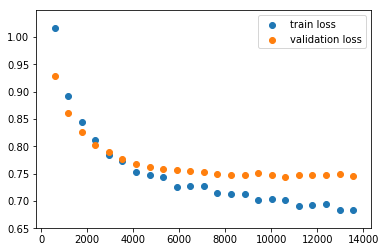

In [19]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

We need to reconstruct the outputs into vectors corresponding to the input.

In [20]:
def reconstruct_predictions(preds, real_vectors):
    preds_rec = []
    cur_idx = 0
    for i in real_vectors:
        assembled = preds[cur_idx:cur_idx+len(i)]
        preds_rec.append(assembled)
        cur_idx += len(i)
    return preds_rec

In [21]:
validation_preds_rec = reconstruct_predictions(validation_preds, validation_reals)

Now we can evaluate the results with Q3 accuracy and segment of overlap. We'll start with the validation set.

In [22]:
def q3_acc(real, pred):
    if real.shape[0] == 1:
        real = np.squeeze(real, 0)
    if pred.shape[0] == 1:
        pred = np.squeeze(pred, 0)   
    return np.sum(real==pred)/real.shape[0]


def segment_of_overlap(ss_ref_str, ss_pred_str):
    ss_ref = get_segments(ss_ref_str)
    ss_pred = get_segments(ss_pred_str)
    val_total = 0
    N_total = 0
    for k in ss_ref.keys():
        subsum_k = 0
        N_k = 0
        for i in ss_ref[k]:
            l_s1 = len(i[1])
            N_k += l_s1
            for j in ss_pred[k]:
                l_s2 = len(j[1])
                minov = len(np.intersect1d(i[1], j[1]))
                if minov > 0:
                    maxov = len(np.union1d(i[1], j[1]))
                    delta = np.min([maxov-minov, minov, np.floor(l_s1/2), np.floor(l_s2/2)])
                    value = l_s1*(minov+delta)/maxov
                    subsum_k += value
        N_total += N_k
        val_total += subsum_k
    sov = val_total/N_total
    return sov

def get_segments(ss_str):
    ss_strs = ["".join(grp) for val, grp in itertools.groupby(ss_str)]
    idx_lens = []
    idx_start = 0
    for i in ss_strs:
        idx_lens.append(np.arange(idx_start, idx_start+len(i)))
        idx_start += len(i)
    segment_types = {'E':[], 'H':[], '-':[]}
    for i in range(len(ss_strs)):
        segment_types[ss_strs[i][0]].append([ss_strs[i], idx_lens[i]])
    return segment_types

def ints_to_symbols1d(ss_arr, map_dict=pos_ss_dict):
    if len(ss_arr.shape) > 1:
        for i,j in enumerate(ss_arr.shape):
            if j == 1:
                ss_arr = np.squeeze(ss_arr, i)
    return "".join([map_dict[i] for i in ss_arr])

In [23]:
val_accuracies = [q3_acc(i,j) for i,j in zip(validation_preds_rec, validation_reals)]
print('CNN validation Q3 accuracy: ', np.mean(val_accuracies))

CNN validation Q3 accuracy:  0.6753099947962968


Since we're not really going to search for any hyperparameters, we can just evaluate the test set and also compare with psipred.

In [24]:
test_preds = np.concatenate([np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in testloader])
test_reals = [tensorize_ss(test_items[i]['ss'], ss_id_dict, tensorize=False) for i in test_ids_filt]
test_preds_rec = reconstruct_predictions(test_preds, test_reals)

In [25]:
test_accuracies_cnn =[q3_acc(i,j) for i,j in zip(test_preds_rec, test_reals)]

In [26]:
def parse_psipred(prot_id, letter_to_number=ss_id_dict):
    ss = ''
    with open('/Users/Deathvoodoo/big_folders_docs/ss_pred/ss_predictions_psipred/{}.horiz'.format(prot_id)) as input:
        lines = input.readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            if len(line)>0:
                if line[0] == 'Pred:' and len(line)>1:
                    ss += line[1]

    ss = ss.replace('C', '-') # psipred predictions use C instead of - for non sheet/helix
    ss = np.array([letter_to_number[i] for i in ss])
    return ss
    

In [27]:
psipred_preds = [parse_psipred(i) for i in test_ids_filt]

In [28]:
psipred_acc = [q3_acc(i,j) for i,j in zip(psipred_preds, test_reals)]

In [29]:
print('CNN Q3 accuracy on test set: ',np.mean(test_accuracies_cnn))
print('psipred Q3 accuracy on test set: ',np.mean(psipred_acc))

CNN Q3 accuracy:  0.6730800099449464
psipred Q3 accuracy:  0.7255188449781512


Let's check segment of overlap score.

In [30]:
test_preds_str_cnn = [ints_to_symbols1d(i) for i in test_preds_rec]
test_preds_str_psipred = [ints_to_symbols1d(i) for i in psipred_preds]
test_reals_str = [ints_to_symbols1d(i) for i in test_reals] # same as grabbing strings directly from the dict

In [31]:
test_sovs_cnn = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_cnn, test_reals_str)]
test_sovs_psipred = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_psipred, test_reals_str)]

print('CNN SOV on test set: ', np.mean(test_sovs_cnn))
print('psipred SOV on test set: ', np.mean(test_sovs_psipred))


CNN SOV:  0.7172306616025629
psipred SOV:  0.7850154998573716
